<a href="https://colab.research.google.com/github/zahra-zarrabi/Face-Age-Regression/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install wandb

In [ ]:
cd '/content/drive/MyDrive/Face Age Regression/dataset'

/content/drive/MyDrive/Face Age Regression/dataset


In [ ]:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [ ]:
# !kaggle datasets download -d jangedoo/utkface-new
# !unzip utkface-new.zip

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import wandb

In [ ]:
wandb.init(project='Face Age Regression')

**hyper parameters**

In [ ]:
epochs=50
width=height=64
batch_size=4
lr=0.001

# Dataset

In [ ]:
images=[]  #X
ages=[]    #Y

for image_name in os.listdir('crop_part1')[:9000]:
  parts=image_name.split('_')
  ages.append(int(parts[0]))

  image=cv2.imread(f'crop_part1/{image_name}')
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  images.append(image)
del image

In [ ]:
images=pd.Series(images,name='Images')
ages=pd.Series(ages,name='Ages')
df=pd.concat([images,ages],axis=1)
df.head()


,Images,Ages
0,"[[[3, 0, 2], [3, 0, 2], [5, 0, 6], [7, 2, 8], ...",6
1,"[[[210, 217, 209], [210, 217, 209], [210, 217,...",82
2,"[[[202, 200, 175], [197, 195, 170], [191, 189,...",90
3,"[[[154, 129, 89], [151, 126, 86], [147, 117, 7...",8
4,"[[[144, 95, 63], [146, 97, 65], [150, 101, 69]...",75


In [ ]:
del images
del ages

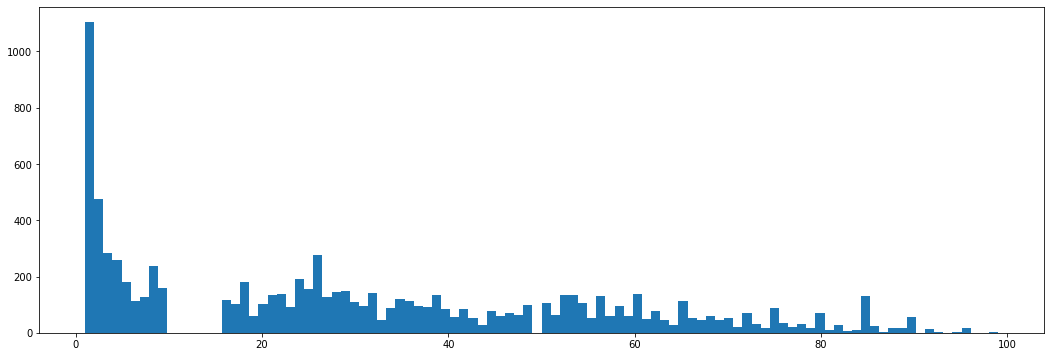

In [ ]:
plt.figure(figsize=(18,6))
plt.hist(df['Ages'],bins=100)
plt.show()

In [ ]:
under_4=[]
for i in range(len(df)):
  if df['Ages'].iloc[i] <=4:
    under_4.append(df.iloc[i])
under_4=pd.DataFrame(under_4)
under_4=under_4.sample(frac=0.3)

up_4=df[df['Ages']>4]
df=pd.concat([under_4,up_4])

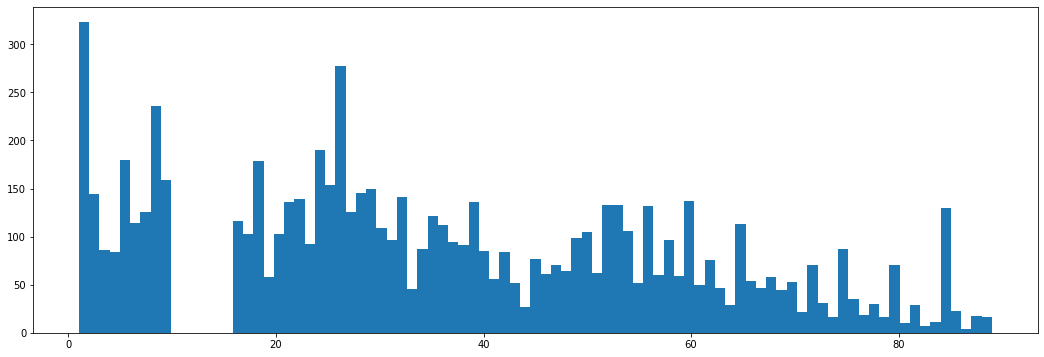

In [ ]:
df=df[df['Ages']<90]
plt.figure(figsize=(18,6))
plt.hist(df['Ages'],bins=89)
plt.show()

In [ ]:
X=[]
Y=[]
for i in range(len(df)):
  df['Images'].iloc[i]=cv2.resize(df['Images'].iloc[i],(width,height))
  X.append(df['Images'].iloc[i])
  Y.append(df['Ages'].iloc[i])

X=np.array(X)
Y=np.array(Y)

In [ ]:
Y=Y.reshape(Y.shape[0],1)

In [ ]:
class CustomDataset(Dataset):
  def __init__(self,x,y,transform=None):
    super().__init__()
    self.image = x
    self.target = y
    self.transform=transform

  def __getitem__(self,index):
    x = self.image[index]
    y = self.target[index]
    
    if self.transform:
      x = self.transform(x)

    return x,y

  def __len__(self):
    return len(self.image)

In [ ]:
transform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToPILImage(),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.RandomHorizontalFlip(),
                                            torchvision.transforms.Normalize((0),(1))
])

dataset=CustomDataset(X,Y,transform=transform)
train_size=int(len(dataset)*0.8)
val_size=len(dataset)-train_size
train_data ,val_data = torch.utils.data.random_split(dataset,[train_size,val_size])

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1)
    self.cnn1_bn = nn.BatchNorm2d(32)
    self.cnn2= nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1) 
    self.cnn2_bn = nn.BatchNorm2d(64)
    self.cnn3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
    self.cnn3_bn = nn.BatchNorm2d(128)
    self.cnn4= nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1) 
    self.cnn4_bn = nn.BatchNorm2d(256)

    self.fc1= nn.Linear(16384,128)
    self.fc2= nn.Linear(128,1)
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = self.cnn1(x)
    x = self.cnn1_bn(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=(2,2))

    x = self.cnn2(x)
    x = self.cnn2_bn(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=(2,2))

    x = self.cnn3(x)
    x = self.cnn3_bn(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=(2,2))

    x = self.cnn4(x)
    x = self.cnn4_bn(x)
    x = F.relu(x)
    # x = F.max_pool2d(x, kernel_size=(2,2))

    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    # x = torch.dropout(x, 0.3,train=True)
    x = self.fc2(x)
    # x = torch.softmax(x, dim=1)

    return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model()
model = model.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
loss_function = nn.L1Loss()

In [ ]:
def train(model, train_data_loader,epoch):
  model.train(True)
  train_loss=0.0
  train_acc=0.0
  for images,labels in tqdm(train_data_loader):
    # images=images.to(torch.float32)
    labels=labels.to(torch.float32)
    images=images.to(device)
    labels=labels.to(device)
    
    optimizer.zero_grad()
    preds_train = model(images)
    loss_train=loss_function(preds_train,labels) # loss_train
    loss_train.backward()
    optimizer.step()
    train_loss += loss_train
    
  total_loss = train_loss/len(train_data_loader)

  print(f"loss_train:{total_loss}")

  wandb.log({'epochs':  epoch,
             'loss_train': total_loss})

In [ ]:
def test(model, val_data_loader,epoch):
  model.eval()
  test_loss=0
  test_acc=0
  for images,labels in tqdm(val_data_loader):    
    images=images.to(device)
    labels=labels.to(device)
    preds_test = model(images)

    loss_test=loss_function(preds_test,labels) 

    test_loss += loss_test

  total_loss = test_loss/len(val_data_loader)

  print(f"loss_eval:{total_loss}")

  wandb.log({'epochs':  epoch,
             'loss_eval': total_loss})

In [ ]:
for epoch in range(epochs):
  print(f'Epoch:{epoch}')
  train(model, train_data_loader, epoch)
  test(model, val_data_loader, epoch)

Epoch:0


100%|██████████| 1484/1484 [00:14<00:00, 104.57it/s]


loss_train:13.690690040588379


100%|██████████| 371/371 [00:01<00:00, 200.30it/s]


loss_eval:10.197965621948242
Epoch:1


100%|██████████| 1484/1484 [00:14<00:00, 101.42it/s]


loss_train:10.350700378417969


100%|██████████| 371/371 [00:01<00:00, 240.65it/s]


loss_eval:10.218388557434082
Epoch:2


100%|██████████| 1484/1484 [00:14<00:00, 102.92it/s]


loss_train:9.079239845275879


100%|██████████| 371/371 [00:01<00:00, 251.24it/s]


loss_eval:9.51550006866455
Epoch:3


100%|██████████| 1484/1484 [00:14<00:00, 105.75it/s]


loss_train:8.455622673034668


100%|██████████| 371/371 [00:01<00:00, 235.56it/s]


loss_eval:8.588814735412598
Epoch:4


100%|██████████| 1484/1484 [00:14<00:00, 103.47it/s]


loss_train:8.01955509185791


100%|██████████| 371/371 [00:01<00:00, 242.97it/s]


loss_eval:8.717629432678223
Epoch:5


100%|██████████| 1484/1484 [00:14<00:00, 102.38it/s]


loss_train:7.434833526611328


100%|██████████| 371/371 [00:01<00:00, 236.38it/s]


loss_eval:8.051229476928711
Epoch:6


100%|██████████| 1484/1484 [00:15<00:00, 98.78it/s]


loss_train:7.0213775634765625


100%|██████████| 371/371 [00:01<00:00, 238.96it/s]


loss_eval:8.487996101379395
Epoch:7


100%|██████████| 1484/1484 [00:14<00:00, 99.08it/s] 


loss_train:6.679635524749756


100%|██████████| 371/371 [00:01<00:00, 217.28it/s]


loss_eval:7.464104652404785
Epoch:8


100%|██████████| 1484/1484 [00:14<00:00, 99.65it/s] 


loss_train:6.445058822631836


100%|██████████| 371/371 [00:01<00:00, 243.26it/s]


loss_eval:8.18747329711914
Epoch:9


100%|██████████| 1484/1484 [00:15<00:00, 98.81it/s] 


loss_train:6.1911468505859375


100%|██████████| 371/371 [00:01<00:00, 239.98it/s]


loss_eval:7.724168300628662
Epoch:10


100%|██████████| 1484/1484 [00:14<00:00, 100.70it/s]


loss_train:5.981722354888916


100%|██████████| 371/371 [00:01<00:00, 237.69it/s]


loss_eval:7.307242393493652
Epoch:11


100%|██████████| 1484/1484 [00:14<00:00, 103.63it/s]


loss_train:5.723778247833252


100%|██████████| 371/371 [00:01<00:00, 238.40it/s]


loss_eval:7.667041301727295
Epoch:12


100%|██████████| 1484/1484 [00:14<00:00, 101.96it/s]


loss_train:5.56868839263916


100%|██████████| 371/371 [00:01<00:00, 240.24it/s]


loss_eval:6.922493934631348
Epoch:13


100%|██████████| 1484/1484 [00:14<00:00, 102.14it/s]


loss_train:5.170668125152588


100%|██████████| 371/371 [00:01<00:00, 234.49it/s]


loss_eval:6.619089126586914
Epoch:14


100%|██████████| 1484/1484 [00:14<00:00, 99.63it/s] 


loss_train:5.085050106048584


100%|██████████| 371/371 [00:01<00:00, 236.00it/s]


loss_eval:6.92698860168457
Epoch:15


100%|██████████| 1484/1484 [00:14<00:00, 101.76it/s]


loss_train:4.959685325622559


100%|██████████| 371/371 [00:01<00:00, 235.74it/s]


loss_eval:6.7173380851745605
Epoch:16


100%|██████████| 1484/1484 [00:14<00:00, 103.14it/s]


loss_train:4.703439235687256


100%|██████████| 371/371 [00:01<00:00, 238.93it/s]


loss_eval:6.9784836769104
Epoch:17


100%|██████████| 1484/1484 [00:15<00:00, 98.11it/s]


loss_train:4.610254287719727


100%|██████████| 371/371 [00:01<00:00, 235.71it/s]


loss_eval:6.666611671447754
Epoch:18


100%|██████████| 1484/1484 [00:14<00:00, 99.40it/s] 


loss_train:4.443273544311523


100%|██████████| 371/371 [00:01<00:00, 231.75it/s]


loss_eval:6.936462879180908
Epoch:19


100%|██████████| 1484/1484 [00:14<00:00, 99.57it/s] 


loss_train:4.365959644317627


100%|██████████| 371/371 [00:01<00:00, 231.08it/s]


loss_eval:6.561511993408203
Epoch:20


100%|██████████| 1484/1484 [00:14<00:00, 103.82it/s]


loss_train:4.164417266845703


100%|██████████| 371/371 [00:01<00:00, 235.40it/s]


loss_eval:6.39133358001709
Epoch:21


100%|██████████| 1484/1484 [00:14<00:00, 99.86it/s] 


loss_train:3.9828264713287354


100%|██████████| 371/371 [00:01<00:00, 244.16it/s]


loss_eval:6.6321587562561035
Epoch:22


100%|██████████| 1484/1484 [00:15<00:00, 98.16it/s]


loss_train:4.013537406921387


100%|██████████| 371/371 [00:01<00:00, 232.14it/s]


loss_eval:6.482797622680664
Epoch:23


100%|██████████| 1484/1484 [00:14<00:00, 100.16it/s]


loss_train:3.8426756858825684


100%|██████████| 371/371 [00:01<00:00, 236.17it/s]


loss_eval:6.345739364624023
Epoch:24


100%|██████████| 1484/1484 [00:14<00:00, 103.16it/s]


loss_train:3.750891923904419


100%|██████████| 371/371 [00:01<00:00, 237.25it/s]


loss_eval:6.571814060211182
Epoch:25


100%|██████████| 1484/1484 [00:14<00:00, 102.64it/s]


loss_train:3.6868698596954346


100%|██████████| 371/371 [00:01<00:00, 238.95it/s]


loss_eval:6.466882228851318
Epoch:26


100%|██████████| 1484/1484 [00:14<00:00, 102.13it/s]


loss_train:3.563401699066162


100%|██████████| 371/371 [00:01<00:00, 242.15it/s]


loss_eval:6.7740960121154785
Epoch:27


100%|██████████| 1484/1484 [00:14<00:00, 100.39it/s]


loss_train:3.5640950202941895


100%|██████████| 371/371 [00:01<00:00, 241.30it/s]


loss_eval:6.5915727615356445
Epoch:28


100%|██████████| 1484/1484 [00:15<00:00, 98.83it/s]


loss_train:3.510612726211548


100%|██████████| 371/371 [00:01<00:00, 239.82it/s]


loss_eval:6.447021484375
Epoch:29


100%|██████████| 1484/1484 [00:15<00:00, 98.66it/s]


loss_train:3.446038246154785


100%|██████████| 371/371 [00:01<00:00, 230.62it/s]


loss_eval:6.591576099395752
Epoch:30


100%|██████████| 1484/1484 [00:14<00:00, 100.31it/s]


loss_train:3.244924306869507


100%|██████████| 371/371 [00:01<00:00, 218.29it/s]


loss_eval:6.4686431884765625
Epoch:31


100%|██████████| 1484/1484 [00:15<00:00, 98.53it/s]


loss_train:3.2858774662017822


100%|██████████| 371/371 [00:01<00:00, 233.77it/s]


loss_eval:6.3249430656433105
Epoch:32


100%|██████████| 1484/1484 [00:14<00:00, 103.38it/s]


loss_train:3.148023843765259


100%|██████████| 371/371 [00:01<00:00, 238.42it/s]


loss_eval:6.345006942749023
Epoch:33


100%|██████████| 1484/1484 [00:14<00:00, 102.25it/s]


loss_train:3.083613157272339


100%|██████████| 371/371 [00:01<00:00, 235.87it/s]


loss_eval:6.390771389007568
Epoch:34


100%|██████████| 1484/1484 [00:14<00:00, 102.82it/s]


loss_train:3.0755417346954346


100%|██████████| 371/371 [00:01<00:00, 230.19it/s]


loss_eval:6.425995826721191
Epoch:35


100%|██████████| 1484/1484 [00:14<00:00, 102.25it/s]


loss_train:2.986574411392212


100%|██████████| 371/371 [00:01<00:00, 236.77it/s]


loss_eval:6.603868007659912
Epoch:36


100%|██████████| 1484/1484 [00:14<00:00, 100.90it/s]


loss_train:2.9931893348693848


100%|██████████| 371/371 [00:01<00:00, 234.64it/s]


loss_eval:6.292699337005615
Epoch:37


100%|██████████| 1484/1484 [00:15<00:00, 97.04it/s]


loss_train:2.904088258743286


100%|██████████| 371/371 [00:01<00:00, 237.31it/s]


loss_eval:6.433676719665527
Epoch:38


100%|██████████| 1484/1484 [00:15<00:00, 96.26it/s]


loss_train:2.913241386413574


100%|██████████| 371/371 [00:01<00:00, 232.09it/s]


loss_eval:6.440661907196045
Epoch:39


100%|██████████| 1484/1484 [00:15<00:00, 98.33it/s] 


loss_train:2.8351521492004395


100%|██████████| 371/371 [00:01<00:00, 244.79it/s]


loss_eval:6.251443862915039
Epoch:40


100%|██████████| 1484/1484 [00:15<00:00, 98.28it/s] 


loss_train:2.7391698360443115


100%|██████████| 371/371 [00:01<00:00, 231.18it/s]


loss_eval:6.2880659103393555
Epoch:41


100%|██████████| 1484/1484 [00:14<00:00, 101.54it/s]


loss_train:2.759800672531128


100%|██████████| 371/371 [00:01<00:00, 240.63it/s]


loss_eval:6.1485161781311035
Epoch:42


100%|██████████| 1484/1484 [00:14<00:00, 101.98it/s]


loss_train:2.689013957977295


100%|██████████| 371/371 [00:01<00:00, 238.16it/s]


loss_eval:6.230645179748535
Epoch:43


100%|██████████| 1484/1484 [00:14<00:00, 104.14it/s]


loss_train:2.6130483150482178


100%|██████████| 371/371 [00:01<00:00, 236.68it/s]


loss_eval:6.191431045532227
Epoch:44


100%|██████████| 1484/1484 [00:14<00:00, 103.26it/s]


loss_train:2.605241060256958


100%|██████████| 371/371 [00:01<00:00, 241.65it/s]


loss_eval:6.256620407104492
Epoch:45


100%|██████████| 1484/1484 [00:14<00:00, 102.93it/s]


loss_train:2.6233341693878174


100%|██████████| 371/371 [00:01<00:00, 241.83it/s]


loss_eval:6.218205451965332
Epoch:46


100%|██████████| 1484/1484 [00:14<00:00, 104.10it/s]


loss_train:2.5455517768859863


100%|██████████| 371/371 [00:01<00:00, 237.08it/s]


loss_eval:6.151088714599609
Epoch:47


100%|██████████| 1484/1484 [00:14<00:00, 99.71it/s] 


loss_train:2.524632692337036


100%|██████████| 371/371 [00:01<00:00, 233.13it/s]


loss_eval:6.313126564025879
Epoch:48


100%|██████████| 1484/1484 [00:15<00:00, 97.64it/s] 


loss_train:2.466890335083008


100%|██████████| 371/371 [00:01<00:00, 227.11it/s]


loss_eval:6.250471115112305
Epoch:49


100%|██████████| 1484/1484 [00:15<00:00, 98.61it/s]


loss_train:2.4526867866516113


100%|██████████| 371/371 [00:01<00:00, 238.25it/s]

loss_eval:6.104147911071777


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Face Age Regression/age_weight.pth")